In [1194]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from astropy.io import fits
import galsim
from dataset import get_COSMOS_Galaxy, get_LSST_PSF

%matplotlib inline

In [1195]:
# COSMOS_dir = '/mnt/WD6TB/tianaoli/COSMOS_23.5_training_sample/' # path to your COSMOS data
COSMOS_dir = '/Users/luke/Downloads/COSMOS_23.5_training_sample' # path to your COSMOS data
catalog = galsim.RealGalaxyCatalog(dir=COSMOS_dir, sample=str(23.5))

fov_pixels = 32
pixel_scale = 0.2
gal_max_shear = 0.5
seeing = 0.7
atmos_max_shear = 0.2

(0.0, 6000.0)

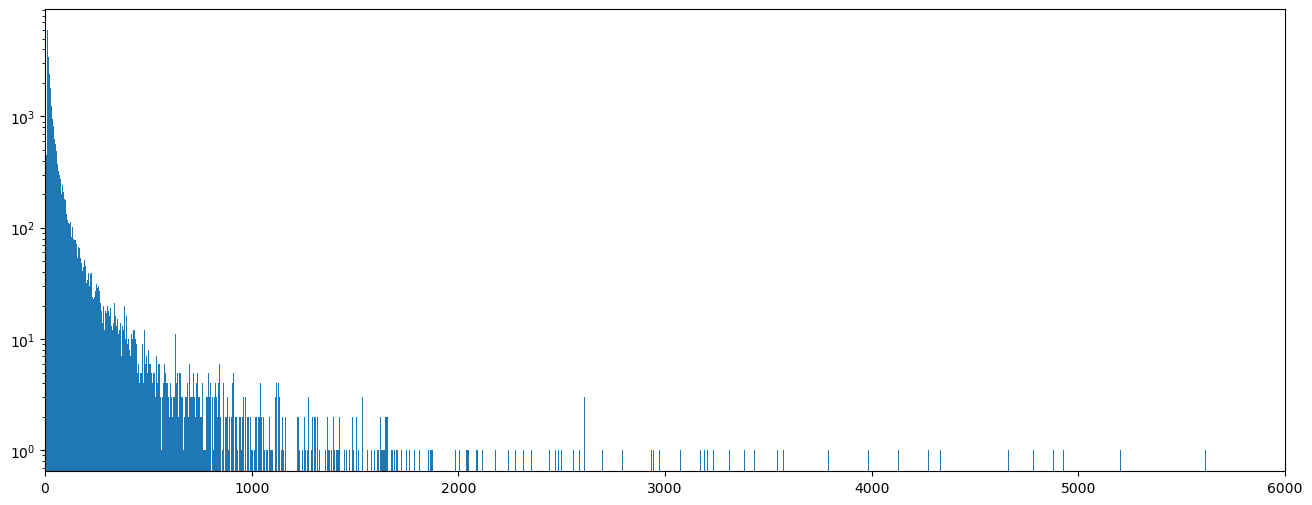

In [1196]:
info = fits.getdata(os.path.join(COSMOS_dir, 'real_galaxy_catalog_23.5_fits.fits'), 1)

ind = np.where(info['viable_sersic'] == 1)

s_flux_Sersic = info['FLUX'][:,0][ind]

s_hlr = info['HLR'][:,0][ind] #In arcsec
s_n = info['sersicfit'][:,2][ind] #Sersic index

s_flux_Sersic.sort()

plt.figure(figsize=(16,6))
plt.hist(s_flux_Sersic[:-2], bins=5000)
plt.yscale('log')
plt.xlim(0, 6000)

In [1205]:
len(info['sersicfit'][:,2])

56062

In [1198]:
rng = galsim.UniformDeviate(seed=19) # Initialize the random number generator
rng_gaussian = galsim.GaussianDeviate(seed=34, mean=seeing, sigma=0.18)
# PSF parameters
atmos_fwhm = 0.6 # arcsec (mean 0.7 for LSST)
# while atmos_fwhm < 0.35 or atmos_fwhm > 1.1: # sample fwhm
#     atmos_fwhm = rng_gaussian()
# atmos_e = rng() * atmos_max_shear # ellipticity of atmospheric PSF
atmos_e = 0.6 * atmos_max_shear
# atmos_beta = 2. * np.pi * rng()     # radians
atmos_beta = 2. * np.pi * 0.5     # radians
atmos_shear = galsim.Shear(e=atmos_e, beta=atmos_beta * galsim.radians)
opt_defocus = 0.3 + 0.4 * rng()     # wavelengths
opt_a1 = 2*0.5*(rng() - 0.5)        # wavelengths (-0.29)
opt_a2 = 2*0.5*(rng() - 0.5)        # wavelengths (0.12)
opt_c1 = 2*1.*(rng() - 0.5)         # wavelengths (0.64)
opt_c2 = 2*1.*(rng() - 0.5)         # wavelengths (-0.33)
opt_obscuration = 0.165             # linear scale size of secondary mirror obscuration $(3.4/8.36)^2$
lam = 700                           # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 8.36 # telescope diameter / meters (8.36 for LSST, 6.5 for JWST)
pixel_scale = pixel_scale

lam_over_diam = lam * 1.e-9 / tel_diam # radians
lam_over_diam *= 206265  # arcsec
optics = galsim.OpticalPSF( lam_over_diam = lam_over_diam,
                            defocus = opt_defocus,
                            coma1 = opt_c1, coma2 = opt_c2,
                            astig1 = opt_a1, astig2 = opt_a2,
                            obscuration = opt_obscuration,
                            flux=1)

# Define the atmospheric component of PSF
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm, flux=1) # Note: the flux here is the default flux=1.
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)
psf = galsim.Convolve([atmos, optics], real_space=True)

# add extra shear error
# psf = psf.shear(g1=g1_err, g2=g2_err)

psf_image = galsim.ImageF(fov_pixels, fov_pixels)
psf.drawImage(psf_image, scale=pixel_scale, method='auto')
# psf_image = torch.from_numpy(psf_image.array)
# psf_im = torch.max(torch.zeros_like(psf_image), psf_image)

print(psf_image.array.min(), psf_image.array.max(), psf_image.array.mean(), psf_image.array.sum())

1.8249696e-06 0.05208718 0.00097170385 0.99502474


In [1199]:
idx = 346 # index pf galaxy in the catalog
rng_gal_shear = galsim.DistDeviate(seed=rng, function=lambda x: x, x_min=0.01, x_max=0.05)
# Galaxy parameters 
gal_g = rng_gal_shear()       # shear of galaxy
gal_beta = 2. * np.pi * rng()       # radians
# gal_shear = galsim.Shear(g=gal_g, beta=gal_beta*galsim.radians)
gal_mu = 1 + rng() * 0.1            # mu = ((1-kappa)^2 - g1^2 - g2^2)^-1 (1.082)
theta = 2. * np.pi * rng()          # radians
# sky_level = 1000                      # ADU / arcsec^2
dx, dy = 2 * rng() - 1, 2 * rng() - 1

snr_list = [200, 100, 50, 20, 10]

# gal_flux = info['FLUX'][:,0][idx]
gal_flux = 70
print(f"gal_flux={gal_flux}")
# Read out real galaxy from catalog
# gal_ori = galsim.RealGalaxy(catalog, index = idx, flux = gal_flux)
# psf_ori = catalog.getPSF(i=idx)
# gal_ori = galsim.Convolve([psf_ori, gal_ori]) # concolve wth original PSF of HST

gal_ori = galsim.Sersic(n=s_n[idx], half_light_radius=s_hlr[idx], flux=gal_flux)

gal = gal_ori.rotate(theta * galsim.radians) # Rotate by a random angle
gal = gal.shear(g=gal_g, beta=gal_beta * galsim.radians) # Apply the desired shear
gal = gal.magnify(gal_mu) # Also apply a magnification mu = ( (1-kappa)^2 - |gamma|^2 )^-1, this conserves surface brightness, so it scales both the area and flux.

gal_image = galsim.ImageF(fov_pixels, fov_pixels)
gal.drawImage(gal_image, scale=pixel_scale, offset=(dx,dy), method='real_space')
# gal_image += sky_level * (pixel_scale**2)
# gal_image = torch.from_numpy(gal_image.array)
# gt = torch.max(torch.zeros_like(gal_image), gal_image)

img_list = [gal_image.array]

gal_flux=70


In [1200]:

# Convolution via FFT
# conv = ifftshift(ifft2(fft2(psf) * fft2(gt))).real
# conv = torch.max(torch.zeros_like(conv), conv) # set negative pixels to zero
# # Add CCD noise (Poisson + Gaussian)
# obs = torch.poisson(conv) + torch.normal(mean=torch.zeros_like(conv), std=2*torch.ones_like(conv))
# obs_ori = torch.max(torch.zeros_like(obs), obs) # set negative pixels to zero
read_noise = 0.14
obs = galsim.Convolve([psf, gal])
for snr in snr_list: 
    obs_image = galsim.ImageF(fov_pixels, fov_pixels)
    obs.drawImage(obs_image, scale=pixel_scale, offset=(dx,dy), method='auto')
    
    sky_level_pixel = (gal_image.array**2).sum()/(snr**2) - read_noise**2
    print(sky_level_pixel)
    
    # noise = galsim.CCDNoise(rng=rng, read_noise=read_noise, sky_level=sky_level_pixel) # Generate Noise
    # obs_image.addNoiseSNR(noise=noise, snr=snr, preserve_flux=True)
    
    noise = galsim.GaussianNoise(rng=rng, sigma=np.sqrt(sky_level_pixel + read_noise**2)) # Generate Noise
    obs_image.addNoiseSNR(noise=noise, snr=snr, preserve_flux=True)

    img_list.append(obs_image.array + sky_level_pixel)
    print(obs_image.array.min(), obs_image.array.max(), obs_image.array.mean(), obs_image.array.sum())
snr_list.insert(0, np.Inf)

-0.013682474899291995
-0.11993204 1.7629879 0.06925045 70.91246
0.004070100402832028
-0.1853453 1.7662414 0.06723906 68.8528
0.07508040161132812
-0.5651335 1.9022369 0.06455898 66.1084
0.5721525100708008
-0.9845339 2.2029393 0.06353771 65.062614
2.347410040283203
-1.7916093 2.693833 0.048248067 49.40602


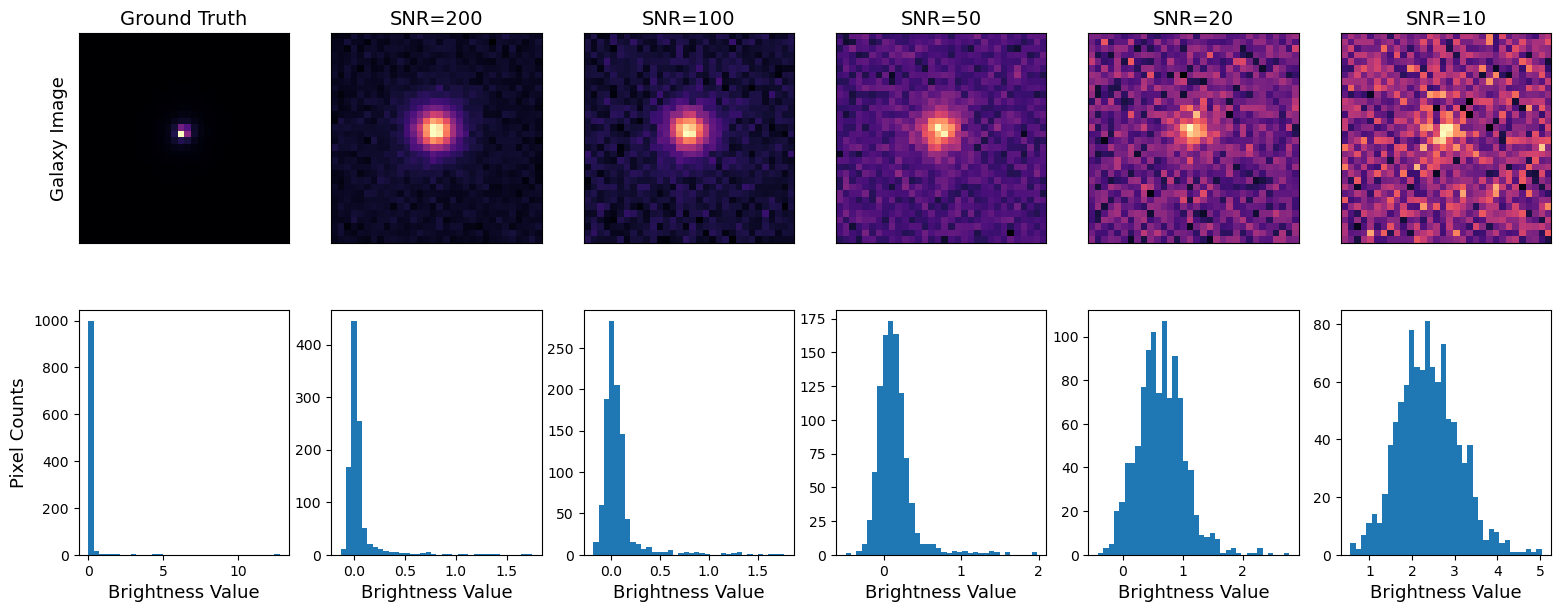

In [1201]:
fig = plt.figure(figsize=(19,7))

vmax = np.max([obs.max() for obs in img_list])
vmin = np.min([obs.min() for obs in img_list])
norm = matplotlib.colors.Normalize(vmax=vmax, vmin=0)

for idx, (snr, obs) in enumerate(zip(snr_list, img_list)):

    ax = plt.subplot(2,len(img_list),idx+1)
    # norm = matplotlib.colors.Normalize(vmax=obs.max(), vmin=0)
    plt.imshow(obs, cmap='magma')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Ground Truth' if idx==0 else f'SNR={snr}', fontsize=14)
    if idx == 0:
        plt.ylabel(f'Galaxy Image', fontsize=13)
    # elif idx == len(img_list) - 1:
    #     cax = fig.add_axes([ax.get_position().x1+6e-3, ax.get_position().y0, 7e-3, ax.get_position().height])
    #     plt.colorbar(cax=cax)
    
    plt.subplot(2,len(img_list),idx+len(img_list)+1)
    plt.hist(obs.ravel(), bins=36)
    # plt.xlim(0,)
    plt.xlabel('Brightness Value', fontsize=13)
    if idx == 0:
        plt.ylabel(f'Pixel Counts', fontsize=13)